# Grid Map
Useful Resources:
- "An Efficient FastSLAM Algorithm for Generating Maps of Large-Scale Cyclic Environments from Raw Laser Range Measurements", 2003, Thrun et al.

- OpenSLAM.com: https://github.com/OpenSLAM-org/openslam_gridslam/tree/master/src

In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [9]:
push!(LOAD_PATH, "src");
include("src/pose.jl")
include("src/measurements.jl");

In [4]:
#nbx --fname=src/grid_map.jl 
using MyUtils
using Colors, Plots
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));

In [5]:
Tuple{Int}

Tuple{Int64}

# The high-level idea

In [10]:
#nbx
logit(p::Real)   = log(p/(1 -p));
ell(p::Real)     = logit(p);
expit(ell::Real) = 1 - 1/(1 + exp(ell));

export logit, ell, expit

In [11]:
#nbx
abstract type AbstractGridMap{C} end

function Base.getindex(m::AbstractGridMap{C}, cell::C) where C error("Not implemented") end
function Base.setindex!(m::AbstractGridMap{C}, v::Float64, cell::C) where C error("Not implemented") end
function on_map(cell::C, m::AbstractGridMap{C}) where C error("Not implemented") end

export AbstractGridMap

## Bayesian update for grid maps

In [12]:
#nbx
function update!(m::AbstractGridMap, p::Pose, s::Measurement; args...)
    for c in affected_cells(m, p, s)
        if !on_map(c, m); 
            continue
        end;
        
        # Cell occupancy from beam model ...
        w = cell_occupancy(c, m, p, s; args...)
        
        # Bayesian cell update
        # Todo: cite reference
        m[c] = clamp(m[c] + ell(w) - ell(m.prior), ell(1e-6), ell(1.0 - 1e-6))
    end
    return m
end
    
function update!(m::AbstractGridMap, p::Pose, ss::Vector{Measurement}; args...)
    for s in ss
            update!(m, p, s; args...)
    end
    return m
end;
export update!

## `AbstractGridMap{CartesianIndex}`

In [13]:
#nbx
"""
Discretize into bins of diameter r, bin-centers lie 
at `z - k*r` for intergers `k`.
"""
quantize(x, r; zero=0) = Int(floor((x + r/2 - zero)/r))
export quantize

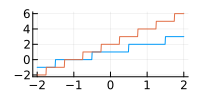

In [14]:
xs  = -2:0.01:2
# ----------------- 
plot(size=(200,100))
plot!(xs, quantize.(xs, 1.0; zero=-1), legend=nothing)
plot!(xs, quantize.(xs, 0.5; zero=-1), legend=nothing)

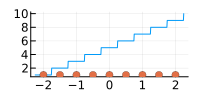

In [15]:
# Grid index in 1D:
# 1. Shift by leftmost cell, and  
# 2. Adjust from zero- to one-indexing
r  = .5
xs = -2:r:2
ys = xs[1]-r/2:0.01:xs[end]+r/2
ks = quantize.(ys .- xs[1], r) .+ 1
# -----------------
plot(size=(200,100))
plot!(ys, ks, legend=nothing)
scatter!(xs, ones(size(xs)), legend=nothing)

In [16]:
#nbx
grid_index(x::Vector{Float64}, m::AbstractGridMap{CartesianIndex}) = CartesianIndex((quantize.(x - m.xs[1,1], m.res) .+ 1)...)
on_map(i::CartesianIndex,  m::AbstractGridMap{CartesianIndex}) = prod(1 .<= Tuple(i) .<= m.shape)
on_map(x::Vector{Float64}, m::AbstractGridMap{CartesianIndex}) = on_map(grid_index(x,m), m::AbstractGridMap)
Base.getindex( m::AbstractGridMap{CartesianIndex}, i::CartesianIndex) = m.vs[i]
Base.getindex( m::AbstractGridMap{CartesianIndex}, x::Vector{Float64}) = m.vs[grid_index(x,m)]
Base.setindex!(m::AbstractGridMap{CartesianIndex}, v::Float64, i::CartesianIndex) = m.vs[i] = v
bounding_box(m::AbstractGridMap{CartesianIndex}) = (m.xs[1], m.xs[end])

export grid_index, on_map, bounding_box

In [48]:
#nbx
function Plots.plot!(m::AbstractGridMap{CartesianIndex}, repr=:prob, ticks=false; cmap=:viridis, args...)
    vs = Matrix(m.vs')
    if repr == :raw
        mat = Matrix(vs)
    elseif repr == :prob
        mat = expit.(vs)
    elseif repr == :log
        mat = log.(expit.(vs))
    end
        
    x = m.xs[1]
        
    xticks = m.xs[1][1]-m.res/2:m.res:m.xs[end][1]+m.res/2
    yticks = m.xs[1][2]-m.res/2:m.res:m.xs[end][2]+m.res/2
    if ticks
        plot!(xticks, yticks, cgrad(cmap)(mat),  yflip = false, xticks=xticks, yticks=yticks)
    else
        plot!(xticks, yticks, cgrad(cmap)(mat),  yflip = false)
    end
end;

# Simple Grid Map

In [18]:
#nbx
mutable struct SimpleGridMap <: AbstractGridMap{CartesianIndex}
    shape::Tuple{Int, Int}
    res::Float64
    prior::Float64
    xs::Matrix{Vector{Float64}}
    vs::Matrix{Float64}
    # Normalizing constant, i.e. `sum(expit.(vs))` 
    # We need that later for quicker sampling and evaluating
    # Todo: keep that updated in `update!`
    weight::Float64 
end

In [19]:
#nbx
function SimpleGridMap(shape::Tuple{Int,Int}; res::Float64=1.0, prior::Float64=0.5)
    center = res*([shape[1];shape[2]]/2 + [1,1]/2)
    xs     = [collect.(Iterators.product(1.0:shape[1], 1.0:shape[2]))...]
    xs     = res.*xs .- [center]
    xs     = reshape(xs, shape)
    vs     = ell.(zeros(shape) .+ prior)
    w = sum(expit.(vs[:]))
    SimpleGridMap(shape, res, prior, xs, vs, w)
end

function SimpleGridMap(shape::Tuple{Int,Int}, center::Vector{Float64}; res::Float64=1.0, prior::Float64=0.5)
    mid = res*([shape[1];shape[2]]/2 + [1,1]/2)
    xs     = [collect.(Iterators.product(1.0:shape[1], 1.0:shape[2]))...]
    xs     = res.*xs .- [mid - center]
    xs     = reshape(xs, shape)
    vs     = ell.(zeros(shape) .+ prior)
    w = sum(expit.(vs[:]))
    SimpleGridMap(shape, res, prior, xs, vs, w)
end

function weigh!(m::SimpleGridMap) 
    m.weight = sum(expit.(m.vs)) 
end
    
function grid_probs(m::SimpleGridMap)
    probs = expit.(m.vs)
    probs = probs ./ sum(probs)
    return probs
end
    
export SimpleGridMap, weigh!

In [20]:
#nbx
using Bresenham: line
using LinearAlgebra: dot, norm
using BeamModels: beam_model

function affected_cells(m::SimpleGridMap, p::Pose, s::Measurement)
    x = p.x
    z = s.z
    # Todo: find a better endpoint for the line, 
    # maybe let the measurement know about `zmax`
    # so we can use it here ...
    y = (1 + 10*m.res/z)*vector(s)*p
    return line(grid_index(x, m), grid_index(y, m), m.shape)
end
    
    
function cell_occupancy(i::CartesianIndex, m::SimpleGridMap, p::Pose, s::Measurement; free=0.4, args...)    
    ip = grid_index(p.x, m)
    is = grid_index(vector(s)*p, m)
    if !on_map(is, m)
        return free
    end
    c = norm(m.xs[ip] - m.xs[i])
    z = norm(m.xs[ip] - m.xs[is])

    return beam_model(c, z; zmax=100, sig=m.res, res=m.res, 
                            free=free, prior=m.prior, occ=.8, args...)
end
export affected_cells, cell_occupancy

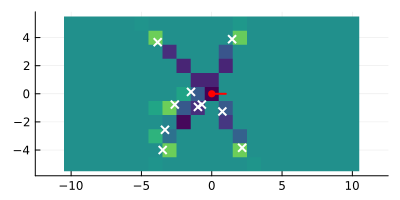

In [21]:
m  = SimpleGridMap((21,11); res=1., prior=0.5)
ss = [Measurement(m.res/2 + rand()*m.res*(minimum(m.shape)-1)/2, rand()*2π) for t=1:10]
p  = Pose()

update!(m, p, ss; free=0.1, occ=1.0)
weigh!(m)
xs = vector.(ss).*p
# ------------------
plot(size=(400,200), aspect_ratio=:equal)
plot!(m, :prob)
scatter!(p, c=:red, linewidth=2)
scatter!(p, ss, marker=:x, c=:white, markerstrokewidth=5.0)

## Map from segements

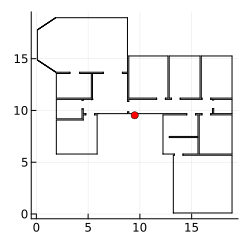

In [28]:
using JLD2
using Plots
using StatsBase: mean
import Geometry
using Geometry: Segment, distance, diff, norm

dist = distance

fname = "data/data_3.jld2"
d = load_object(fname)
segs = env_segs = d[:env][:segs];

center = mean(Geometry.bounding_box(segs))

plot(size=(250,250), aspect_ratio=:equal, legend=false)
plot!(segs, c=:black)
scatter!([center], c=:red)
# plot!(path, marker=:o, label=nothing)

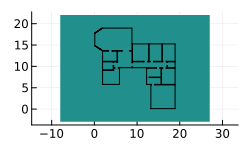

In [33]:
m  = SimpleGridMap((140,100), mean(Geometry.bounding_box(segs)); res=.25, prior=0.5);
plot(size=(250,150), aspect_ratio=:equal, legend=false)
plot!(m)
plot!(segs, c=:black)

## Map from synthetic data

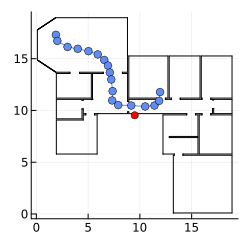

In [35]:
using JLD2
using Plots
using StatsBase: mean

fname = "data/data_3.jld2"
d = load_object(fname)

segs = env_segs = d[:env][:segs];
center = mean(Geometry.bounding_box(segs));
    
xs  = d[:motion][:x];
hds = d[:motion][:hd];
as   = d[:sensor][:a];
zs  = d[:sensor][:z];
ps = [Pose(x,hd) for (x,hd) in zip(xs, hds)];

# -----------------
plot(size=(250,250), aspect_ratio=:equal, legend=false)
plot!(segs, c=:black)
scatter!([center], c=:red)
plot!(xs, marker=:o, label=nothing)

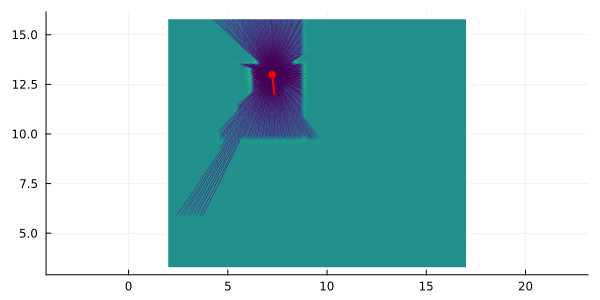

In [40]:
m  = SimpleGridMap((300,250), center; res=.05, prior=0.5)

t = 10
p = ps[t]
ss = [Measurement(z,a) for (a,z) in zip(as,zs[t])]

res = 2*m.res
update_args = Dict(
    :prior=>0.5, 
    :free=>0.2, 
    :occ=>.8, 
    :res=>res, 
    :sig=>2*res)

update!(m, p, ss; update_args...)
weigh!(m)

# ------------------
plot(size=(600,300), aspect_ratio=:equal)
plot!(m, :prob)
scatter!(p, c=:red, linewidth=2)

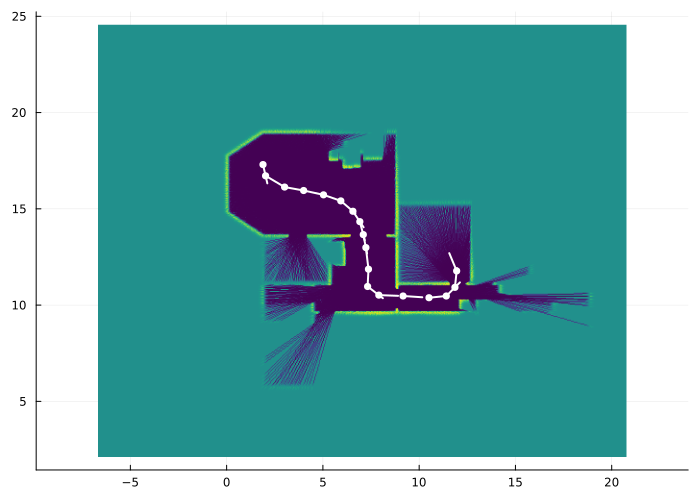

In [64]:
center = mean([p.x for p in ps])
m  = SimpleGridMap((550,450), center; res=.05, prior=0.5)

for t=1:length(zs)
    ss = [Measurement(z,a) for (a,z) in zip(as,zs[t])]
    update!(m, ps[t], ss; update_args...)
end
weigh!(m)

# ------------------
myplot = plot(size=(700,500), aspect_ratio=:equal)
plot!(m, :prob)
scatter!.(ps, c=:white, linewidth=2)
myplot

# Grid Map Distribution

In [63]:
#nbx
using Gen

struct GridMapDistribution <: Gen.Distribution{Vector{Float64}} end
const gridmapdist = GridMapDistribution()

function Gen.logpdf(::GridMapDistribution, x::Vector{Float64}, p::Pose, m::AbstractGridMap{CartesianIndex})    
    # Transfroms x (assumed in pose coordinates) to map coordinates.
    # (syntactic sugar for poses)
    y = x*p  
    
    if !on_map(y, m) return -Inf end
    
    # Todo: make sure `m.weights` is up to date
    # Note: assumes an "ell"-map, i.e. logit values.
    return log(expit(m[y])) - log(1/m.res^2) - log(m.weight)
end

function Gen.random(::GridMapDistribution, p::Pose, m::AbstractGridMap{CartesianIndex})
    # Sample from mixture of all grid cells, 
    # weighted by their occupancy value.
    # Todo: make sure `m.weights` is up to date
    probs = expit.(m.vs[:])
    probs ./= m.weight
    i = categorical(probs)
    x = m.xs[i] + m.res*(rand(2) .- 0.5)
    
    # Transforms from map coordinates into pose's coordinates
    y = x/p
    return y
end

(::GridMapDistribution)(p::Pose, m::AbstractGridMap{CartesianIndex}) = Gen.random(GridMapDistribution(), p, m)
# `false` for now, if `true` I assume I have to define something else so...
Gen.has_output_grad(::GridMapDistribution)    = false;         
Gen.has_argument_grads(::GridMapDistribution) = (false,false); 
export gridmapdist, GridMapDistribution

In [129]:
peak_to_peak(xs) = (xs .- minimum(xs))./(maximum(xs) - minimum(xs))

peak_to_peak (generic function with 1 method)

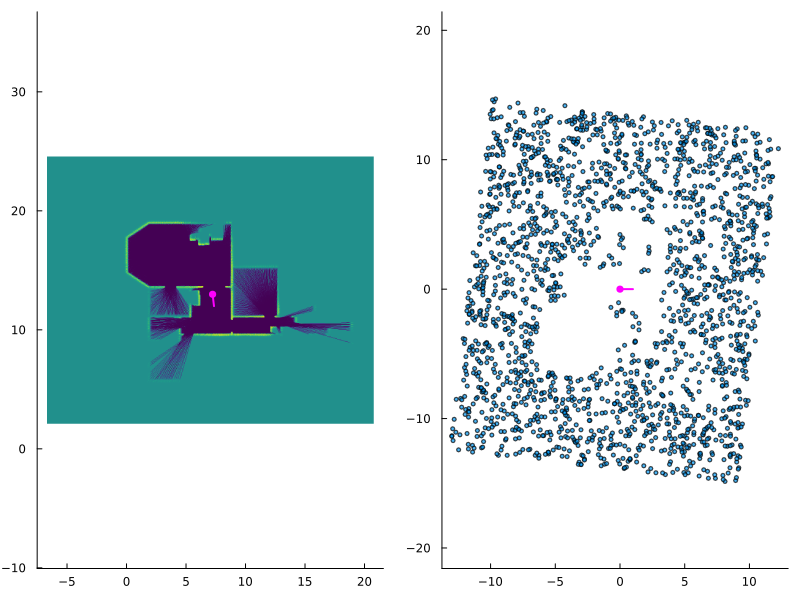

In [78]:
p = ps[10]
samples = [gridmapdist(p, m) for t=1:2_000]
ss = Measurement.(samples)
scores = logpdf.([gridmapdist], samples, p, [m])
scores = peak_to_peak(scores)
perm = sortperm(scores)

# --------------------
p1 = plot(aspect_ratio=:equal, colorbar=false, grid=false)
plot!(m, :prob)
scatter!(p, c=:magenta, linewidth=2)

p2 = plot(aspect_ratio=:equal, colorbar=false, grid=false)
scatter!(Pose(), ss; c=col[1], alpha=0.7, marker=:o, markersize=2)
scatter!(Pose(), c=:magenta, linewidth=2)

plot(p1, p2, size=(800,600), layout = @layout [a b])

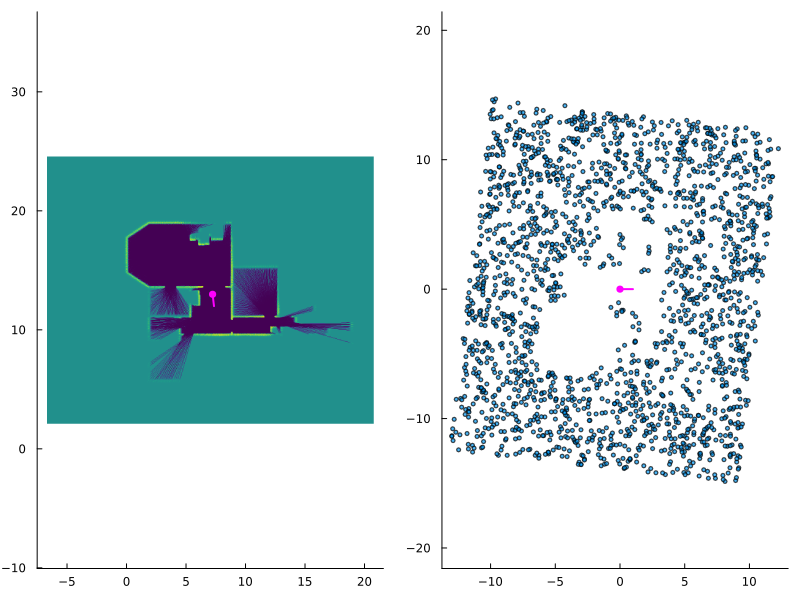

In [80]:
plot(p1, p2, size=(800,600), layout = @layout [a b])